In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import astropy.cosmology as cosmo
from astropy.cosmology import Planck15
import astropy.units as u
import bz2
import corner
import h5py
import pickle
import pystan
from scipy.stats import gaussian_kde
import seaborn as sns

sns.set_context('notebook')
sns.set_style('ticks')
sns.set_palette('colorblind')

First, load the data:

In [3]:
chain = {}
with h5py.File('observations.h5', 'r') as f:
    for n in ['m1det', 'm2det', 'dl', 'log_m1m2dl_wt']:
        chain[n] = array(f['posteriors'][n])
        
#     nn, Tobs = f.attrs['1yr']
#     nn = int(round(nn))
    
#     for k in chain.keys():
#         chain[k] = chain[k][:nn,:]

    Tobs = f.attrs['Tobs']

In [4]:
nsamp = np.round(loadtxt('nsamp_5yr.txt')).astype(np.int)
nsamp_total = np.sum(nsamp)

In [5]:
with h5py.File('selected.h5', 'r') as inp:
    N_gen = inp.attrs['N_gen']

    m1s_det = array(inp['m1det'])
    m2s_det = array(inp['m2det'])
    dls_det = array(inp['dl'])
    wts_det = array(inp['wt'])

In [6]:
nsel = 131072
f = nsel / len(m1s_det)
N_gen = int(round(N_gen*f))
m1s_det = m1s_det[:nsel]
m2s_det = m2s_det[:nsel]
dls_det = dls_det[:nsel]
wts_det = wts_det[:nsel]

In [7]:
ndet = m1s_det.shape[0]
nobs = chain['m1det'].shape[0]

In [8]:
m1 = []
m2 = []
dl = []
log_m1m2dl_wt = []

for i in range(nobs):
    npost = chain['m1det'].shape[1]

    if nsamp[i] > npost:
        # Then we need to draw some extra points.  First we will weight by the
        # inverse prior so that we are sampling the likelihood; then we will
        # draw from a KDE
        logwt = -chain['log_m1m2dl_wt'][i,:]

        rs = (np.max(logwt) + log(rand(npost))) < logwt

        # Cut out any samples with m2_det < 3 (which will be outside our bounds anyway).
        rs = rs & (chain['m2det'][i,:] > 3)

        print('Drawing event {:d} from a KDE; using {:d} points after prior re-weighting'.format(i, count_nonzero(rs)))

        # We draw from a KDE, using a variable transformation to ensure that 0 <
        # m2 < m1 and 0 < dl.  Because we have re-weighted the points,
        # they are drawn from a flat prior in m1obs, m2obs, dl, so we can
        # transform them at will as long as we bring them back to this space in
        # the end.
        p = row_stack((log(chain['m1det'][i,rs]),
                       log(chain['m2det'][i,rs]) - log(chain['m1det'][i,rs]-chain['m2det'][i,rs]),
                       log(chain['dl'][i,rs])))

        kde = gaussian_kde(p)
        pts = kde.resample(nsamp[i])

        ms1 = exp(pts[0,:])
        m1.append(ms1)

        gz = pts[1,:] > 0
        m2.append(where(gz,
                        (ms1)/(exp(-pts[1,:]) + 1),
                        (exp(pts[1,:])*ms1)/(1 + exp(pts[1,:]))))
        dl.append(exp(pts[2,:]))
        log_m1m2dl_wt.append(zeros_like(pts[0,:]))
    else:
        s = np.random.choice(chain['m1det'].shape[1], nsamp[i], replace=False)
        m1.append(chain['m1det'][i,s])
        m2.append(chain['m2det'][i,s])
        dl.append(chain['dl'][i,s])
        log_m1m2dl_wt.append(chain['log_m1m2dl_wt'][i,s])

Drawing event 782 from a KDE; using 582 points after prior re-weighting
Drawing event 884 from a KDE; using 998 points after prior re-weighting
Drawing event 960 from a KDE; using 1085 points after prior re-weighting
Drawing event 1579 from a KDE; using 1545 points after prior re-weighting
Drawing event 1933 from a KDE; using 1118 points after prior re-weighting
Drawing event 2460 from a KDE; using 493 points after prior re-weighting
Drawing event 2773 from a KDE; using 1020 points after prior re-weighting
Drawing event 3295 from a KDE; using 1526 points after prior re-weighting
Drawing event 3601 from a KDE; using 1771 points after prior re-weighting
Drawing event 3962 from a KDE; using 1355 points after prior re-weighting


In [9]:
ninterp = 500
zMax = 10
zinterp = expm1(linspace(log(1), log(zMax+1), ninterp))

msnorm = exp(arange(log(1), log(300), 0.01))
nnorm = len(msnorm)

z_p = 0.75

In [10]:
m = pystan.StanModel(file='model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e9969219fa0e9a62e81a5d3804501978 NOW.
/Users/wfarr/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/35/vcq24mtj2_g5wk96mbck0cw400018s/T/tmpc4ffts2a/stanfit4anon_model_e9969219fa0e9a62e81a5d3804501978_815189888195057836.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [11]:
d = {
    'nobs': nobs,
    'nsel': ndet,
    'ninterp': ninterp,
    'nnorm': nnorm,

    'nsamp': nsamp,
    'nsamp_total': nsamp_total,

    'Tobs': Tobs,
    'N_gen': N_gen,

    'm1obs': np.concatenate(m1),
    'm2obs': np.concatenate(m2),
    'dlobs': np.concatenate(dl),
    'log_m1m2dl_wt': np.concatenate(log_m1m2dl_wt),

    'm1sel': m1s_det,
    'm2sel': m2s_det,
    'dlsel': dls_det,
    'wtsel': wts_det,

    'zinterp': zinterp,

    'ms_norm': msnorm,

    'z_p': z_p,

    'cosmo_prior': 1
}

In [12]:
r = m.vb(data=d, algorithm='fullrank')

In [13]:
class vb_result_wrapper(object):
    def __init__(self, r):
        self._r = r
    @property
    def r(self):
        return self._r
    
    def __getitem__(self, k):
        try:
            i = r['sampler_param_names'].index(k)
            return array(r['sampler_params'][i])
        except:
            rs = []
            j = 1
            while '{:s}[{:d}]'.format(k, j) in r['sampler_param_names']:
                rs.append(r['sampler_params'][r['sampler_param_names'].index('{:s}[{:d}]'.format(k, j))])
                j += 1
            if j > 1:
                return column_stack(rs)
            else:
                raise KeyError('Key not found: {:s}'.format(k))

In [14]:
w = vb_result_wrapper(r)

/Users/wfarr/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Safety factor (1% of Neff / 4*Nobs) = 2.3


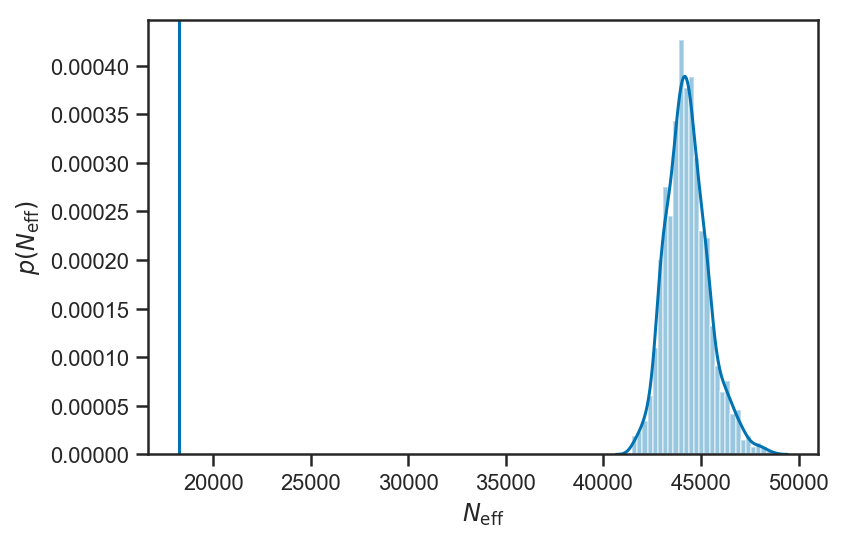

In [15]:
sns.distplot(w['neff_det'])
axvline(4*d['nobs'])
xlabel(r'$N_\mathrm{eff}$')
ylabel(r'$p\left( N_\mathrm{eff}\right)$')

print('Safety factor (1% of Neff / 4*Nobs) = {:.1f}'.format(percentile(w['neff_det'], 1)/(4*d['nobs'])))

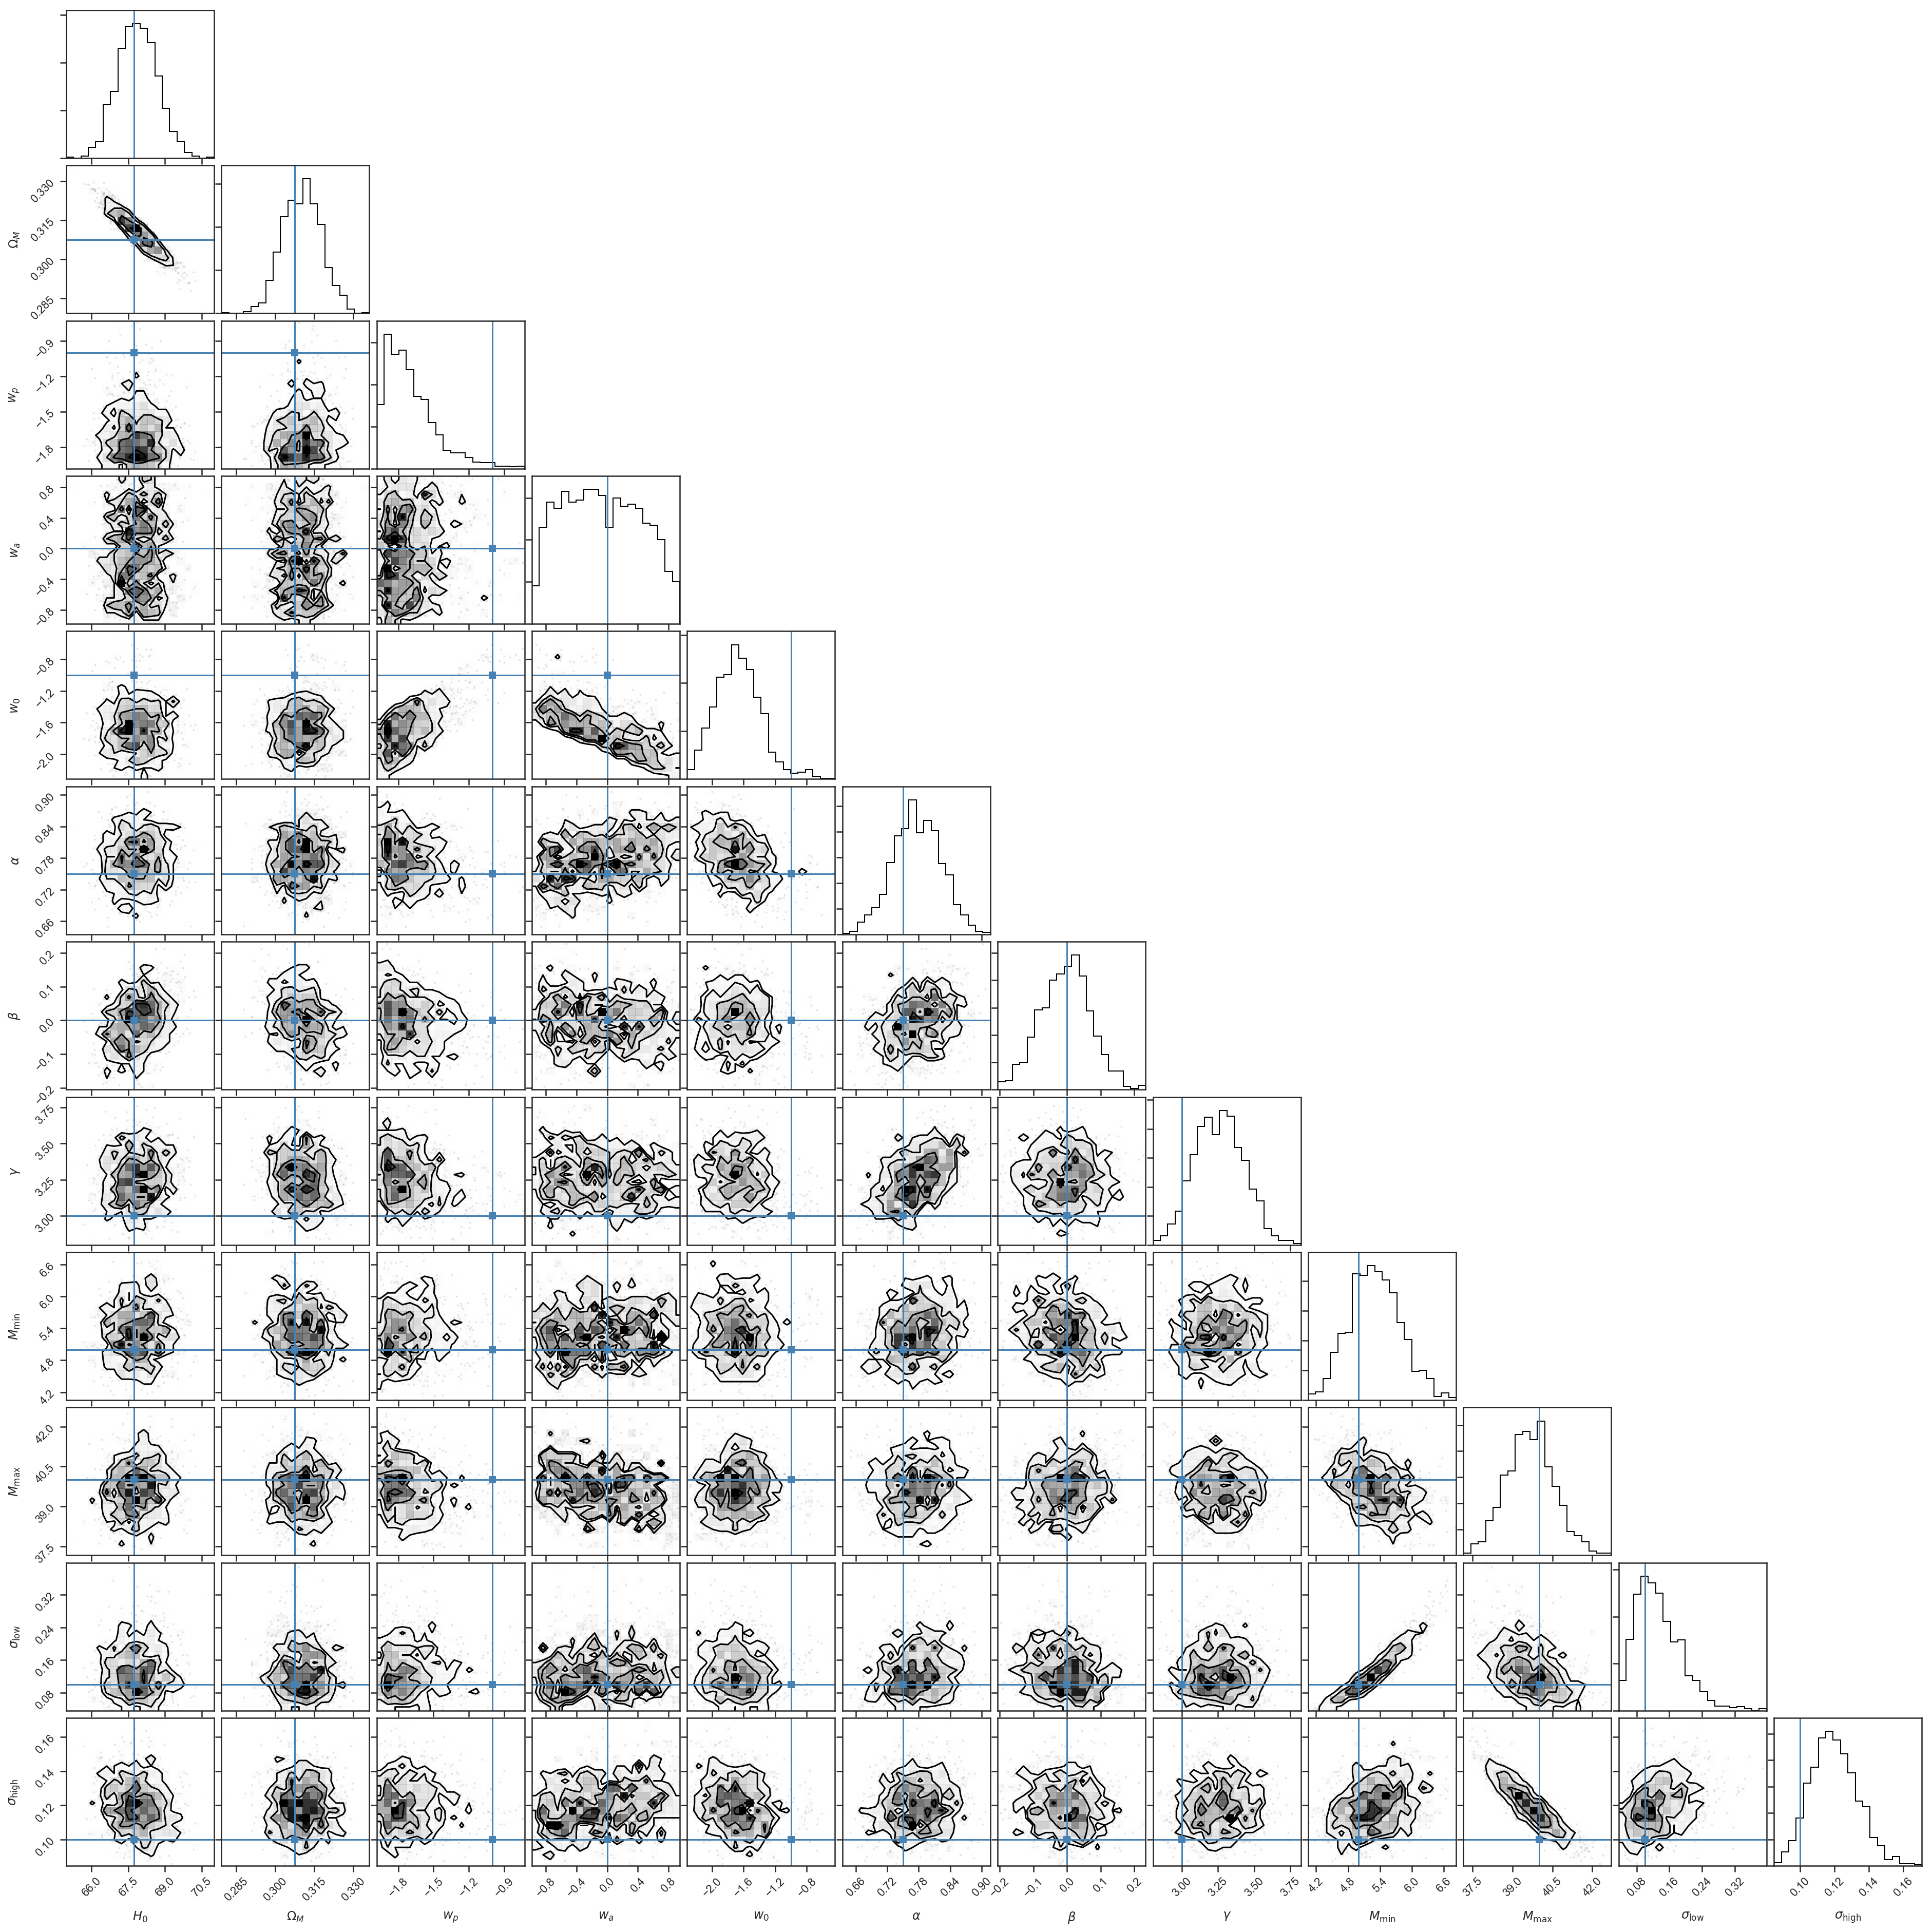

In [16]:
corner.corner(column_stack([w[k] for k in ['H0', 'Om', 'w_p', 'w_a', 'w_0', 'alpha', 'beta', 'gamma', 'MMin', 'MMax', 'sigma_low', 'sigma_high']]),
              labels=[r'$H_0$', r'$\Omega_M$', r'$w_p$', r'$w_a$', r'$w_0$', r'$\alpha$', r'$\beta$', r'$\gamma$', r'$M_\mathrm{min}$', r'$M_\mathrm{max}$', r'$\sigma_\mathrm{low}$', r'$\sigma_\mathrm{high}$'],
              truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, Planck15.Om0, -1.0, 0.0, -1.0, 0.75, 0.0, 3.0, 5.0, 40.0, 0.1, 0.1]);

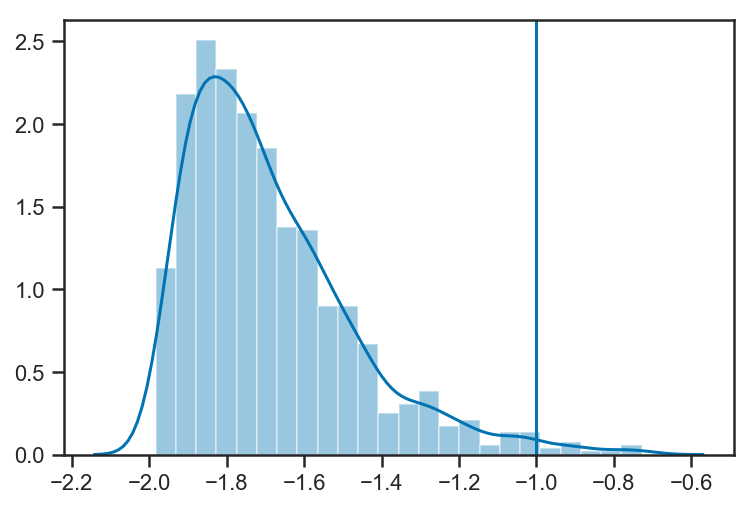

In [17]:
sns.distplot(w['w_p'])
axvline(-1)

In [18]:
print('w_p = {:.2f} +/- {:.2f}'.format(mean(w['w_p']), std(w['w_p'])))

w_p = -1.69 +/- 0.22


In [26]:
# with bz2.BZ2File('1yr-vb.pkl.bz2', 'w') as f:
#     pickle.dump(r, f)